In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


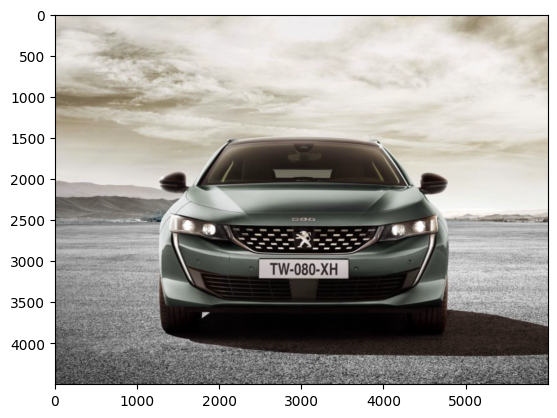

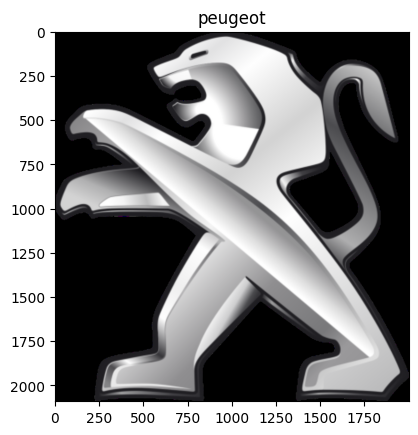

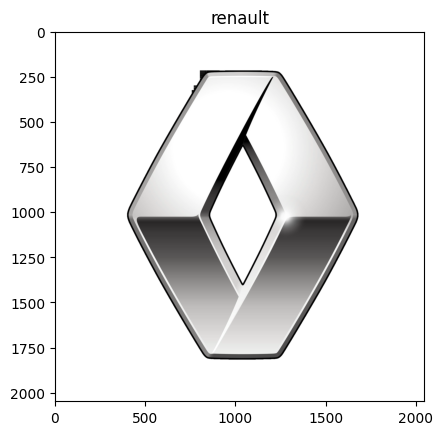

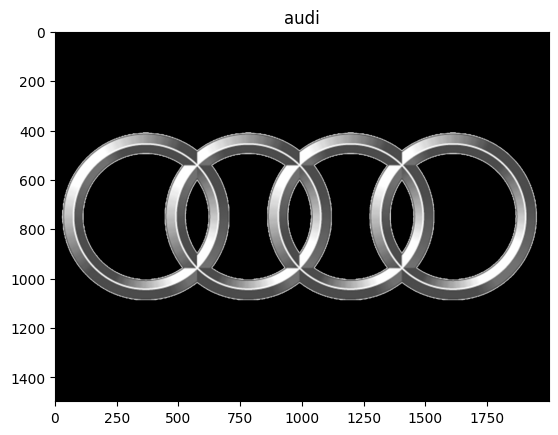

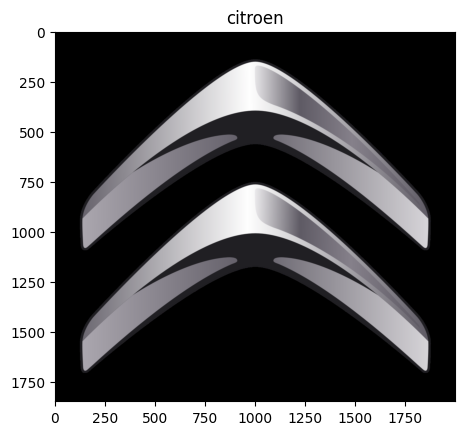

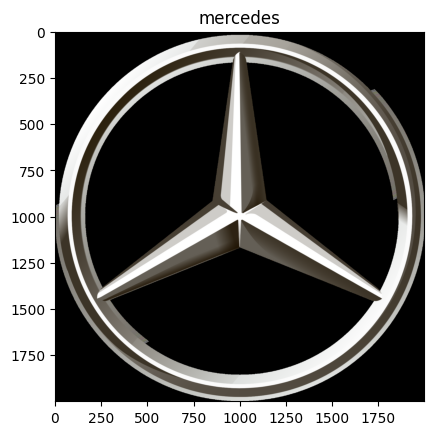

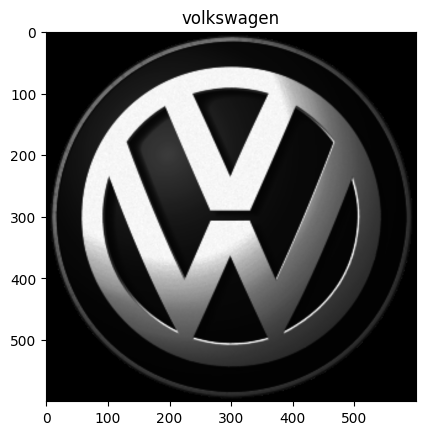

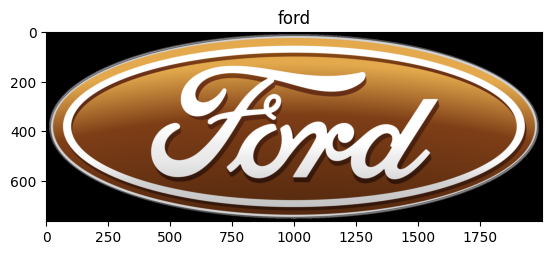

In [53]:
def read_image(file_path):
    return cv2.imread(file_path)

logos = {
    "peugeot": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_peugeot.png"),
    "renault": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_renault.png"),
    "audi": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_audi.png"),
    "citroen": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_citroen.png"),
    "mercedes": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_mercedes.png"),
    "volkswagen": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_volkswagen.png"),
    "ford": read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\logos\\logo_ford.png")
}


test_image = read_image("C:\\Users\\Ajeansquid\\Documents\\projet 2023 2024\\voitures\\peugeot5.jpg")
plt.imshow(test_image)
plt.show()

for logo_name, logo_image in logos.items():
    plt.imshow(logo_image)
    plt.title(logo_name)
    plt.show()



In [51]:
def niv_gris(image):
    if len(image.shape) == 3:
        img_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        img_gris = image
    return img_gris


def ORB(img):
    orb = cv2.ORB_create() # création de l’objet de la classe ORB
    #Extraction des points et des descripteurs
    img_gris = niv_gris(img)
    points, descripteursImg = orb.detectAndCompute(img_gris, None)
    return points, descripteursImg

def SIFT(img):
    sift = cv2.SIFT_create()
    img_gris = niv_gris(img)
    points, descripteursImg = sift.detectAndCompute(img_gris, None)
    return points, descripteursImg

def compa_force_brute_SIFT(img1, img2):
    algoBF = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    points1, descripteurs_img1 = SIFT(img1)
    points2, descripteurs_img2 = SIFT(img2)

   
    paires_corresp = algoBF.knnMatch(descripteurs_img1, descripteurs_img2, k=2)
    

    # Filtrer les correspondances en utilisant le ratio de Lowe
    bonnes_correspondances = []
    ratio_lowe = 0.75
    for m, n in paires_corresp:
        if m.distance < ratio_lowe * n.distance:
            bonnes_correspondances.append(m)
    

    # Dessiner les correspondances
    #img_matches = cv2.drawMatches(img1, points1, img2, points2, bonnes_correspondances, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Redimensionnement de l'image
    #img_matches = cv2.resize(img_matches, dsize=(2000, 1200))

    return bonnes_correspondances

def compa_force_brute_ORB(img1, img2):
    algoBF = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)


    points1, descripteurs_img1 = ORB(img1)
    points2, descripteurs_img2 = ORB(img2)

    
    paires_corresp = algoBF.knnMatch(descripteurs_img1, descripteurs_img2, k=2)
    
    
    # Filtrer les correspondances en utilisant le ratio de Lowe
    bonnes_correspondances = []
    ratio_lowe = 0.75
    for m, n in paires_corresp:
        if m.distance < ratio_lowe * n.distance:
            bonnes_correspondances.append(m)
    

    # Dessiner les correspondances
    #img_matches = cv2.drawMatches(img1, points1, img2, points2, bonnes_correspondances, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Redimensionnement de l'image
    #img_matches = cv2.resize(img_matches, dsize=(2000, 1200))

    #plt.imshow(img_matches)
    #plt.show()

    return bonnes_correspondances


def compare_logos(img_voiture):
    distances_ORB = []
    distances_SIFT = []

    for logo_name, logo_image in logos.items():
        match_ORB = compa_force_brute_ORB(img_voiture, logo_image)
        points1_ORB, _ = ORB(img_voiture)
        points2_ORB, _ = ORB(logo_image)
        distance_ORB = np.mean([np.linalg.norm(np.array(points1_ORB[m.queryIdx].pt) - np.array(points2_ORB[m.trainIdx].pt)) for m in match_ORB])
        distances_ORB.append(distance_ORB)

        match_SIFT = compa_force_brute_SIFT(img_voiture, logo_image)
        points1_SIFT, _ = SIFT(img_voiture)
        points2_SIFT, _ = SIFT(logo_image)
        distance_SIFT = np.mean([np.linalg.norm(np.array(points1_SIFT[m.queryIdx].pt) - np.array(points2_SIFT[m.trainIdx].pt)) for m in match_SIFT])
        distances_SIFT.append(distance_SIFT)

    # Choose the logo that has the smallest Euclidean distance for both methods
    logo_names = list(logos.keys())
    logo_name_ORB = logo_names[distances_ORB.index(min(distances_ORB))]
    logo_name_SIFT = logo_names[distances_SIFT.index(min(distances_SIFT))]

    # If both methods agree on the logo, return that. Otherwise, return None.
    if logo_name_ORB == logo_name_SIFT:
        return logo_name_ORB
    else:
        return logo_name_ORB + " ou " + logo_name_SIFT



In [52]:
print(compare_logos(test_image))


citroen ou audi


-1

-1